# 1. EDA

* Construa uma análise descritiva extraindo conhecimento das variáveis e apresentando quais insights podem ser obtidos a partir delas;

* Mostre-nos um caminho para selecionar graficamente as variáveis mais ou menos importantes para cada problema, como elas se relacionam e porquê.

* Em cada problema descreva quais outras técnicas poderiam ser aplicadas e porquê você não as escolheu.

* Utilize os dados: eda_receitas_data.zip

## 0.0. IMPORTS

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib
import missingno as msno

from pyod.models.knn import KNN
from sklearn.impute import KNNImputer
from IPython.core.display import HTML
from IPython.display import Image
from matplotlib import pyplot as plt
from category_encoders import MEstimateEncoder
from sklearn.impute import SimpleImputer
from tabulate import tabulate

### 0.1. Helper Functions

In [77]:
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.2f' % x)

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
def describe(df, stats):
    d = df.describe()
    return d.append(df.reindex(d.columns, axis = 1).agg(stats))

jupyter_settings()

### 0.2. Loading Data

In [78]:
df_receitas_raw = pd.read_json('datasets/receitas.json')

In [79]:
df_receitas_raw.head()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.00,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.00,None,30.00,2.50,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.00
1,[Combine first 9 ingredients in heavy medium s...,23.00,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.00,This uses the same ingredients found in boudin...,18.00,4.38,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.00
2,[In a large heavy saucepan cook diced fennel a...,7.00,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.00,None,6.00,3.75,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.00
3,[Heat oil in heavy large skillet over medium-h...,NaN,2009-03-27 04:00:00+00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",NaN,The Sicilian-style tomato sauce has tons of Me...,NaN,5.00,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.00,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.00,None,20.00,3.12,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.00


## 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [80]:
df1 = df_receitas_raw.copy()

In [81]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20130 entries, 0 to 20129
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   directions   20111 non-null  object             
 1   fat          15908 non-null  float64            
 2   date         20111 non-null  datetime64[ns, UTC]
 3   categories   20111 non-null  object             
 4   calories     15976 non-null  float64            
 5   desc         13495 non-null  object             
 6   protein      15929 non-null  float64            
 7   rating       20100 non-null  float64            
 8   title        20111 non-null  object             
 9   ingredients  20111 non-null  object             
 10  sodium       15974 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(5), object(5)
memory usage: 1.7+ MB


### 1.1. Check NA

In [82]:
df1.isna().sum()

directions       19
fat            4222
date             19
categories       19
calories       4154
desc           6635
protein        4201
rating           30
title            19
ingredients      19
sodium         4156
dtype: int64

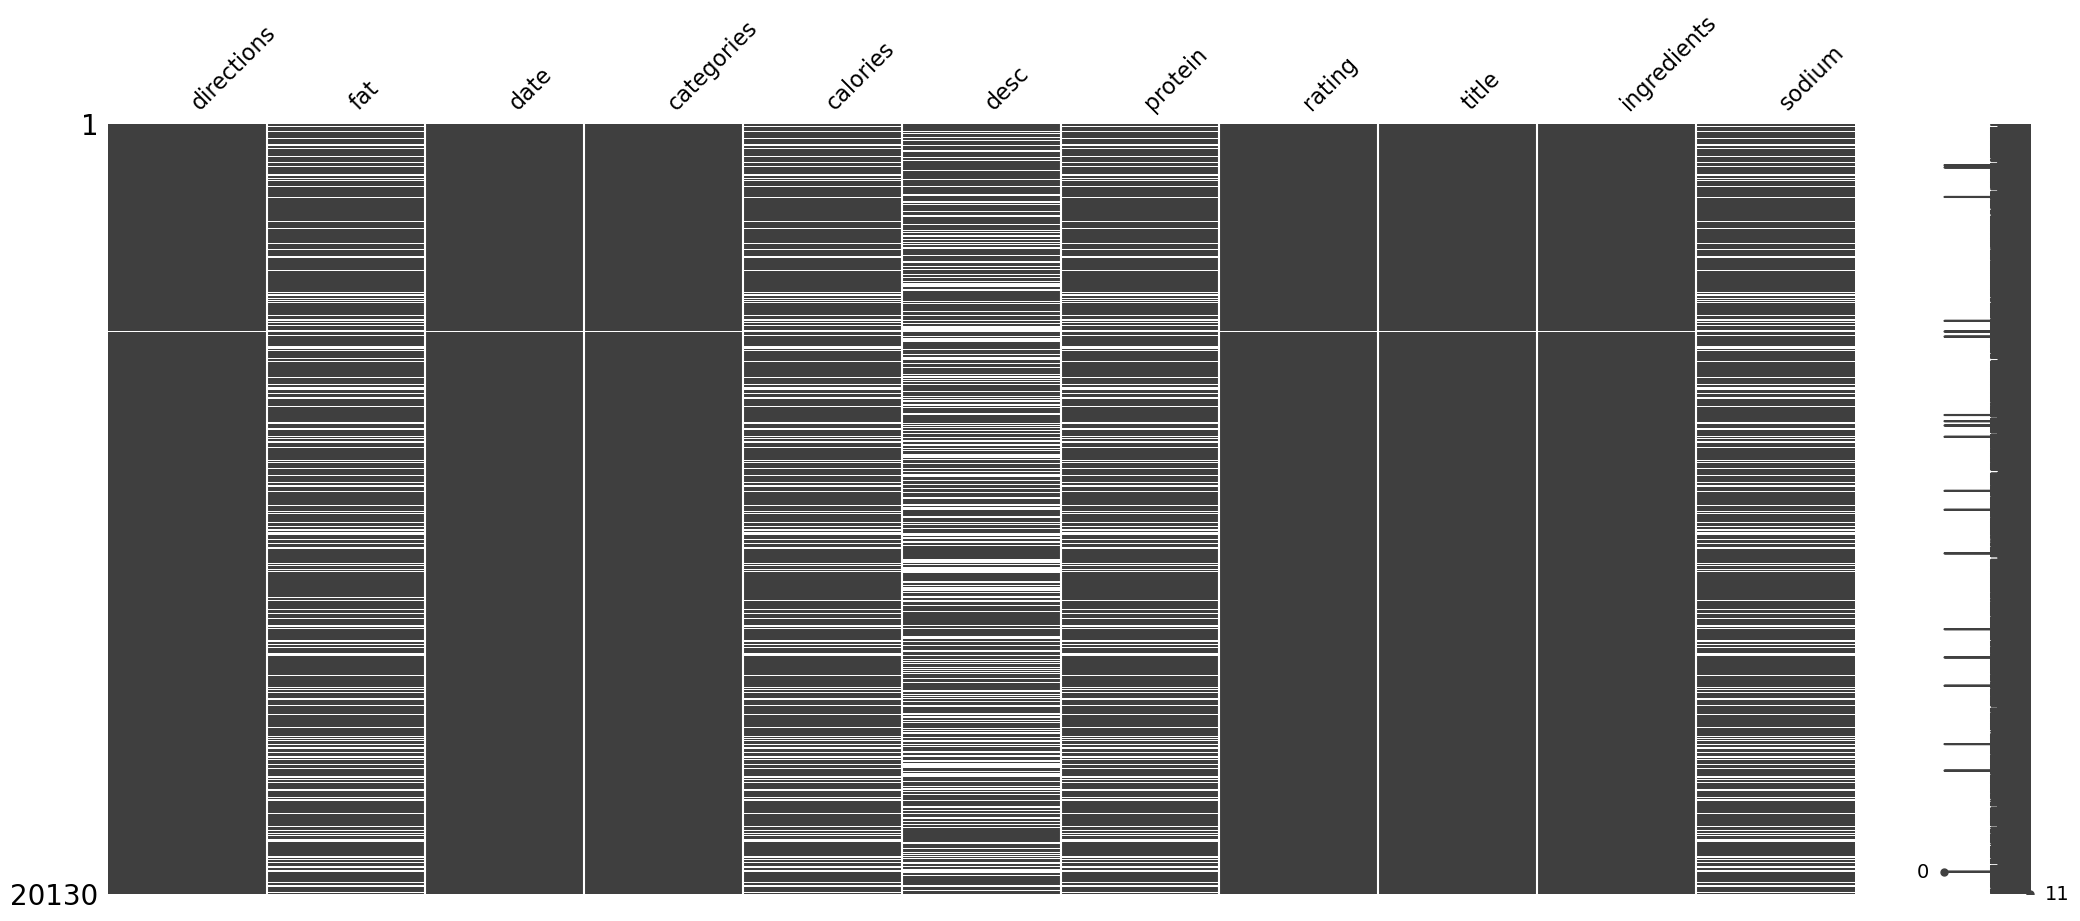

In [83]:
msno.matrix(df1);

In [84]:
df1[df1.title.isnull()]

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
1076,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1135,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1907,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5146,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5424,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5558,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7607,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7768,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7881,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8177,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
df1 = df1.dropna(how='all')

### 1.2. Outliers

In [86]:
# fat
df1['fat'] = df1['fat'].apply(lambda x: None if x > 150 else x)

# calories
df1['calories'] = df1['calories'].apply(lambda x: None if x > 1500 else x)

# protein
df1['protein'] = df1['protein'].apply(lambda x: None if x > 100 else x)

# sodium
df1['sodium'] = df1['sodium'].apply(lambda x: None if x > 3500 else x)

### 1.3. Fillout NA

In [87]:
imputer = KNNImputer(n_neighbors=5)
df1[['fat', 'calories', 'protein', 'sodium']] = pd.DataFrame(imputer.fit_transform(df1[['fat', 'calories', 'protein', 'sodium']]))

In [88]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20111 entries, 0 to 20129
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   directions   20111 non-null  object             
 1   fat          20092 non-null  float64            
 2   date         20111 non-null  datetime64[ns, UTC]
 3   categories   20111 non-null  object             
 4   calories     20092 non-null  float64            
 5   desc         13495 non-null  object             
 6   protein      20092 non-null  float64            
 7   rating       20100 non-null  float64            
 8   title        20111 non-null  object             
 9   ingredients  20111 non-null  object             
 10  sodium       20092 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(5), object(5)
memory usage: 1.8+ MB


In [89]:
describe(df1, ['skew', 'kurt'])

,fat,calories,protein,rating,sodium
count,20092.00,20092.00,20092.00,20100.00,20092.00
mean,24.07,419.61,17.34,3.71,495.07
std,21.53,280.29,18.50,1.34,520.51
min,0.00,0.00,0.00,0.00,0.00
25%,10.00,229.00,4.00,3.75,123.00
50%,23.85,403.16,14.00,4.38,463.00
75%,27.00,497.00,19.00,4.38,556.25
max,150.00,1497.00,100.00,5.00,3491.00
skew,2.05,1.40,1.83,-1.87,2.16
kurt,5.87,2.16,3.42,2.65,5.96


In [91]:
df1.isnull().sum()

directions        0
fat              19
date              0
categories        0
calories         19
desc           6616
protein          19
rating           11
title             0
ingredients       0
sodium           19
dtype: int64

### 1.4. Valores Duplicados

In [93]:
df1[df1.duplicated('title')].shape[0]

2336

In [94]:
df1 = df1.sort_values('rating', ascending=False).drop_duplicates('title', keep = 'first').sort_index()

In [95]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17775 entries, 0 to 20129
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   directions   17775 non-null  object             
 1   fat          17760 non-null  float64            
 2   date         17775 non-null  datetime64[ns, UTC]
 3   categories   17775 non-null  object             
 4   calories     17760 non-null  float64            
 5   desc         11918 non-null  object             
 6   protein      17760 non-null  float64            
 7   rating       17766 non-null  float64            
 8   title        17775 non-null  object             
 9   ingredients  17775 non-null  object             
 10  sodium       17760 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(5), object(5)
memory usage: 1.6+ MB


### 1.5. Estatística Descritiva

In [96]:
num_attributes = df1.select_dtypes (include = ['float64', 'int64'])
cat_attributes = df1.select_dtypes (exclude = ['float64', 'int64', 'datetime64[ns, UTC]'])

#### 1.5.1. Atributos Numéricos

In [97]:
describe(df1, ['skew', 'kurt'])

,fat,calories,protein,rating,sodium
count,17760.00,17760.00,17760.00,17766.00,17760.00
mean,24.08,420.28,17.46,3.73,497.76
std,21.45,279.66,18.55,1.31,521.33
min,0.00,0.00,0.00,0.00,0.00
25%,10.00,230.00,4.00,3.75,124.75
50%,23.85,403.16,15.00,4.38,471.00
75%,27.00,499.00,19.00,4.38,565.00
max,149.00,1497.00,100.00,5.00,3491.00
skew,2.04,1.39,1.82,-1.93,2.16
kurt,5.85,2.16,3.36,2.94,5.90


#### 1.7.2 Atributos Categóricos

In [98]:
cat_attributes

,directions,categories,desc,title,ingredients
0,"[1. Place the stock, lentils, celery, carrot, ...","[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",None,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,..."
1,[Combine first 9 ingredients in heavy medium s...,"[Food Processor, Onion, Pork, Bake, Bastille D...",This uses the same ingredients found in boudin...,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c..."
2,[In a large heavy saucepan cook diced fennel a...,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",None,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk..."
3,[Heat oil in heavy large skillet over medium-h...,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",The Sicilian-style tomato sauce has tons of Me...,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c..."
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",None,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th..."
...,...,...,...,...,...
20124,[Wash spareribs. Remove excess fat and gristle...,"[Pork, Appetizer, Bake, Marinate, Sherry, Fall...",None,Chinese Barbecued Spareribs,"[1 side pork spareribs, about 3 pounds, 1/2 cu..."
20126,[Bring broth to simmer in saucepan.Remove from...,"[Side, Kid-Friendly, High Fiber, Dinner, Parme...",Cooking the artichokes with the rice infuses t...,Artichoke and Parmesan Risotto,"[5 1/2 cups (or more) low-salt chicken broth, ..."
20127,"[Using a sharp knife, cut a shallow X in botto...","[Onion, Poultry, turkey, Vegetable, Bake, Kid-...",None,Turkey Cream Puff Pie,"[1 small tomato, 1 small onion, finely chopped..."
20128,[Heat 2 tablespoons oil in heavy medium skille...,"[Milk/Cream, Citrus, Dairy, Fish, Garlic, Past...","Sharon Hooykaas of Los Alamitos, California, w...",Snapper on Angel Hair with Citrus Cream,"[4 tablespoons olive oil, 4 shallots, thinly s..."


In [99]:
tag = df1["categories"].tolist()
tag = (x for l in tag for x in l)
tag = pd.Series(tag)

In [100]:
len(tag.unique())

673

### 1.8. Insights Passo 01

**1.** directions -> Modo de preparo\
       fat -> Gordura, provavelmente em gramas\
       date -> Data da postagem\
       calories -> Calorias, provavelmente em kcal\
       protein -> Proteínas, provavelmente em g\
       rating -> Nota da receita\
       categories -> Tags de identificação\
       dec -> Feedbacks e informações\
       title -> Nome\
       ingredients -> Ingredientes\
       sodium -> Sódio, provavelmente em mg
       
**2.** Dataset de receitas. Grande chance da feature *rating* servir como target.

**3.** Foi observada uma grande quantidade de NA. Além disso, haviam 19 linhas inteiramente vazias, observadas através da linha horizontal branca na matriz de missing values. Essas linhas foram retiradas do dataframe.

**4.** Foi observado outliers bastante elevados em colunas numéricas, com vários valores extrapolando e muito uma medida próxima da realidade. Para solução, foi considerado, inicialmente, que valores acima de 5x do Q3 fossem substituídos por NAs.

**5.** Para substituição de NAs, utilizou-se o algoritmo KNN Imputer.

**6.** Haviam 2336 receitas com o mesmo nome. As com maiores *rating* dentre as com mesmo nome permanerecam no dataframe.

**7.** Dentre os atributos categóricos, a *categories* possui potencial relevância para a análise. Uma lista *tag* foi criada a partir da feature *categories*.

## 2.0. PASSO 02 - FEATURE ENGINEERING

In [101]:
df2 = df1.copy()

### 2.1. Mind Map de Hipóteses

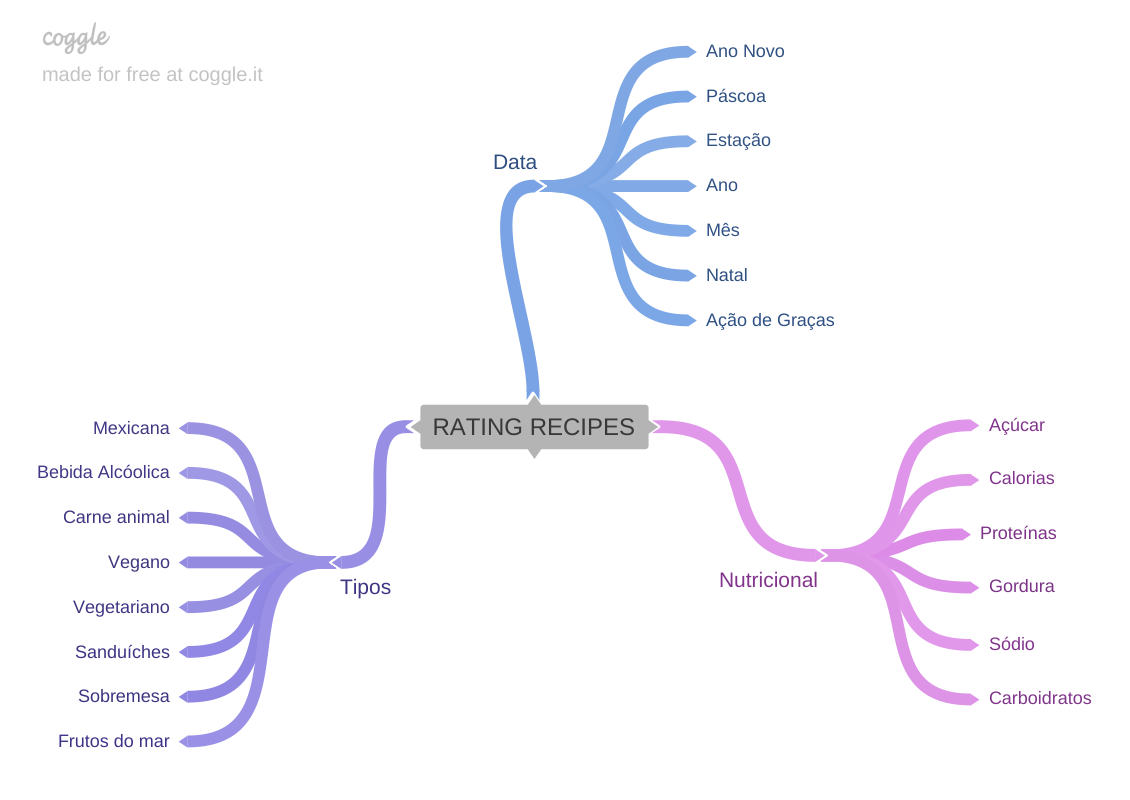

In [102]:
Image('img/RATING_RECIPES.png')

### 2.2. Criação de Hipóteses

#### 2.2.1. Hipóteses Nutricional

**1.** Receitas com mais calorias deveriam possuir menos rating.

**2.** Receitas com mais proteínas deveriam possuir mais rating.

#### 2.2.2. Hipóteses Tipos

**1.** Receitas veganas deveriam possuir menos rating.

**2.** Sobremesas deveriam possuir maior rating.

**3.** Receitas com carne animal deveriam possuir mais rating.

#### 2.2.3. Hipóteses Data

**1.** Receitas postadas próximas ao Natal deveriam possuir mais rating.

**2.** Receitas postadas próximas no verão deveriam possuir mais rating.

**3.** Rating médio deveria aumentar com o passar dos anos.

#### 2.2.4. Hipóteses Entre Elementos

**1.** Receitas postadas no verão deveriam ter mais calorias.

**2.** Receitas veganas deveriam possuir menos proteínas.

**3.** Receitas do tipo *Healthy* deveriam possuir menos gorduras

### 2.3. Feature Engineering

In [103]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# seasons
df2['season'] = df2['month'].apply(lambda x: 'spring' if (x >= 3) & (x < 6) else 'summer' if (x >= 6) & (x < 9) else 'fall' if (x >= 9) & (x < 12) else 'winter') 

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(np.int64)

# vegetariana
df2['veg'] = df2['categories'].apply(lambda x: 1 if 'Vegetarian' in x else 0)

# sobremesa
df2['dessert'] = df2['categories'].apply(lambda x: 1 if 'Dessert' in x else 0)

# churrasco
df2['barbecue'] = df2['categories'].apply(lambda x: 1 if 'Grill/Barbecue' in x else 0)

# saudável
df2['healthy'] = df2['categories'].apply(lambda x: 1 if 'Healthy' in x else 0)

### 2.4. Insights Passo 02

**1.** Para a criação de hipóteses, foi criado um Mind Map com o objetivo de organizar os relacionamentos entre as features.

**2.** Algumas colunas foram criadas através das features originais, para auxiliar na validação das hipóteses.

## 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [104]:
df3 = df2.copy()

### 3.1. Filtragem de Linhas

In [105]:
df3 = df3[df3['rating'] >= 0]

### 3.2. Filtragem de Colunas

In [106]:
cols_drop = ['directions', 'desc']
df3 = df3.drop(cols_drop, axis=1)

### 3.3. Insights Passo 03

**1.** Linhas sem *rating* foram retiradas do dataframe.

**2.** Colunas *directions* e *desc* foram retiradas do dataframe por não possuírem relevância observada.

## 4.0. PASSO 04 - ANÁLISE EXPLORATÓRIA DE DADOS

In [107]:
df4 = df3.copy()

### 4.1. Análise Univariada

#### 4.1.1 Variável Resposta

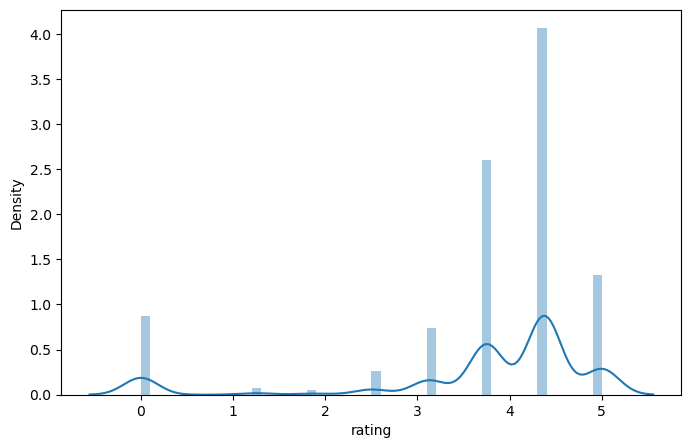

In [108]:
plt.rcParams['figure.figsize'] = [8, 5]
sns.distplot(df4['rating']);

**1.** Há poucos *ratings* baixos no dataframe.

**2.** Pouca variabilidade de *ratings*, com maior concentração em 4.375.

**3.** A pouca variabilidade pode dificultar a geração de insights utilizando-a como variável target.

#### 4.1.2. Variáveis Numéricas

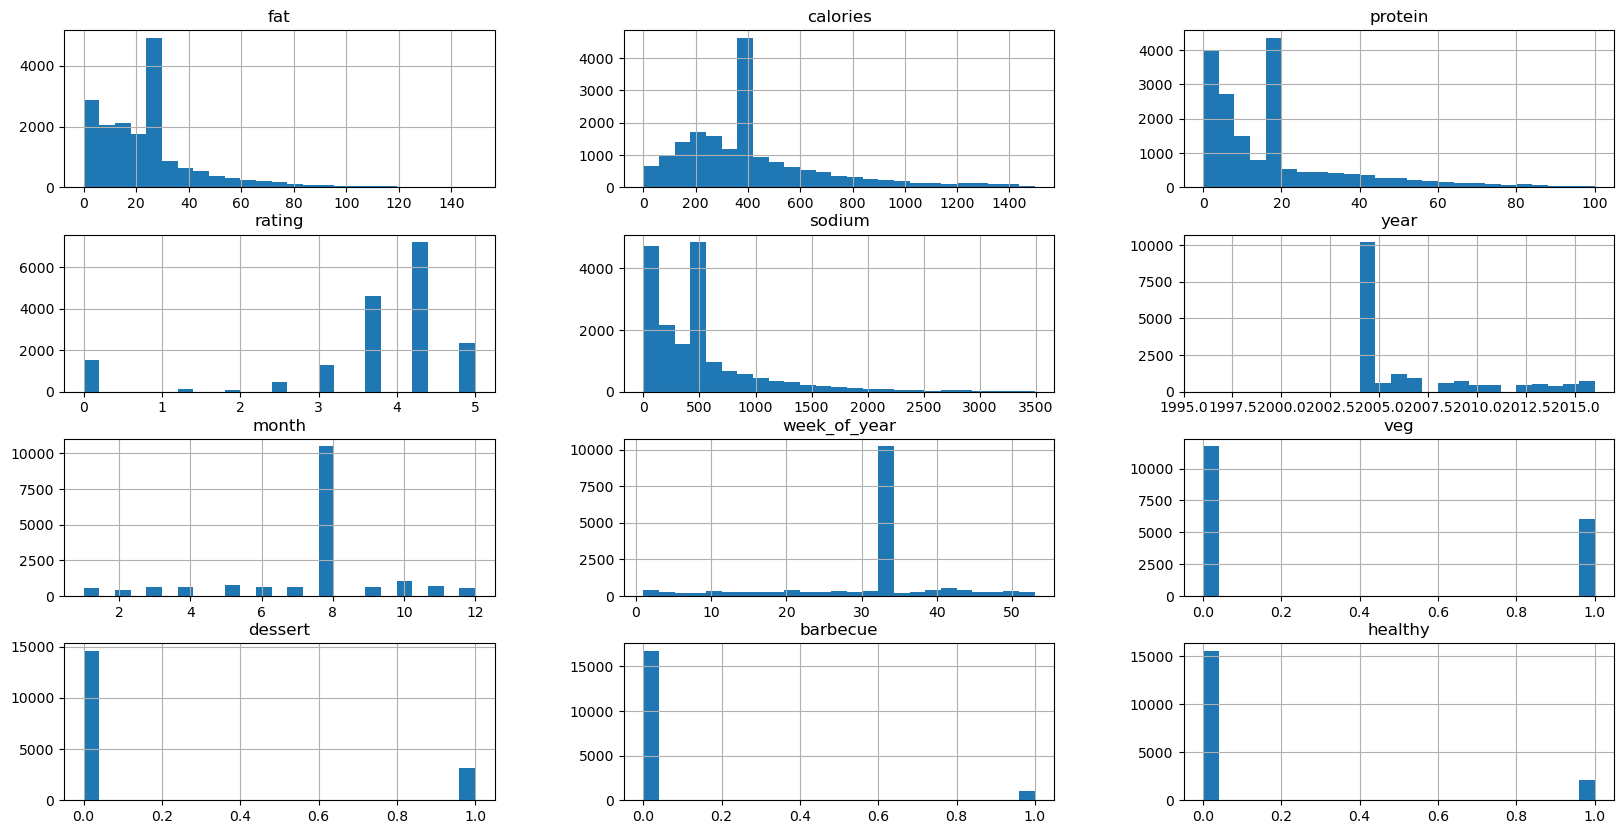

In [124]:
plt.rcParams['figure.figsize'] = [20, 10]
num_attributes = df4.select_dtypes (include = ['float64', 'int64'])
num_attributes.hist (bins = 25);

**4.** Variáveis numéricas nutricionais possuem boa variância, sinalizando potencial de análise.

**5.** Devido ao SimpleImput utilizando a mediana, houve uma concentração de valores nessa área em cada categoria.

#### 4.1.3. Variáveis Categóricas

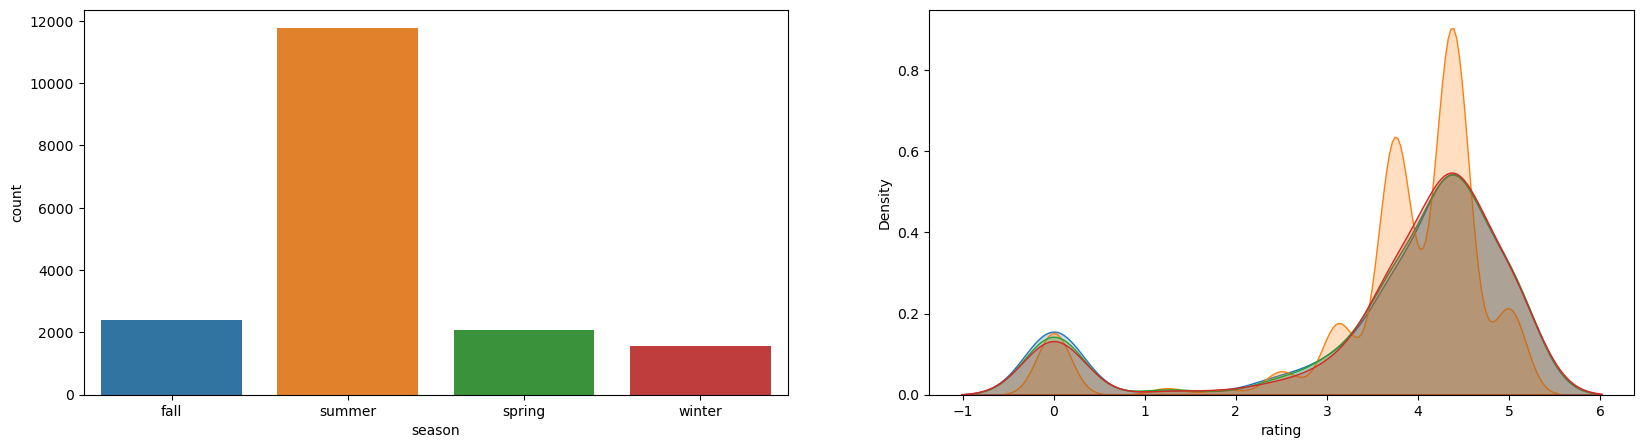

In [110]:
# seasons
plt.rcParams['figure.figsize'] = [20, 5]
plt.subplot (1, 2, 1)
sns.countplot(x = 'season', data = df4)

plt.subplot(1, 2, 2 )
sns.kdeplot(df4[df4['season'] == 'fall']['rating'], label='fall', fill=True);
sns.kdeplot(df4[df4['season'] == 'summer']['rating'], label='summer', fill=True);
sns.kdeplot(df4[df4['season'] == 'spring']['rating'], label='spring', fill=True);
sns.kdeplot(df4[df4['season'] == 'winter']['rating'], label='winter', fill=True);

**6.** A maioria das receitas foram cadastradas durante o verão.

### 4.2. Análise Bivariada

#### H1. Receitas com mais calorias deveriam possuir menos rating.
**FALSO** - Há uma maior concentração de nota máxima em calorias altas

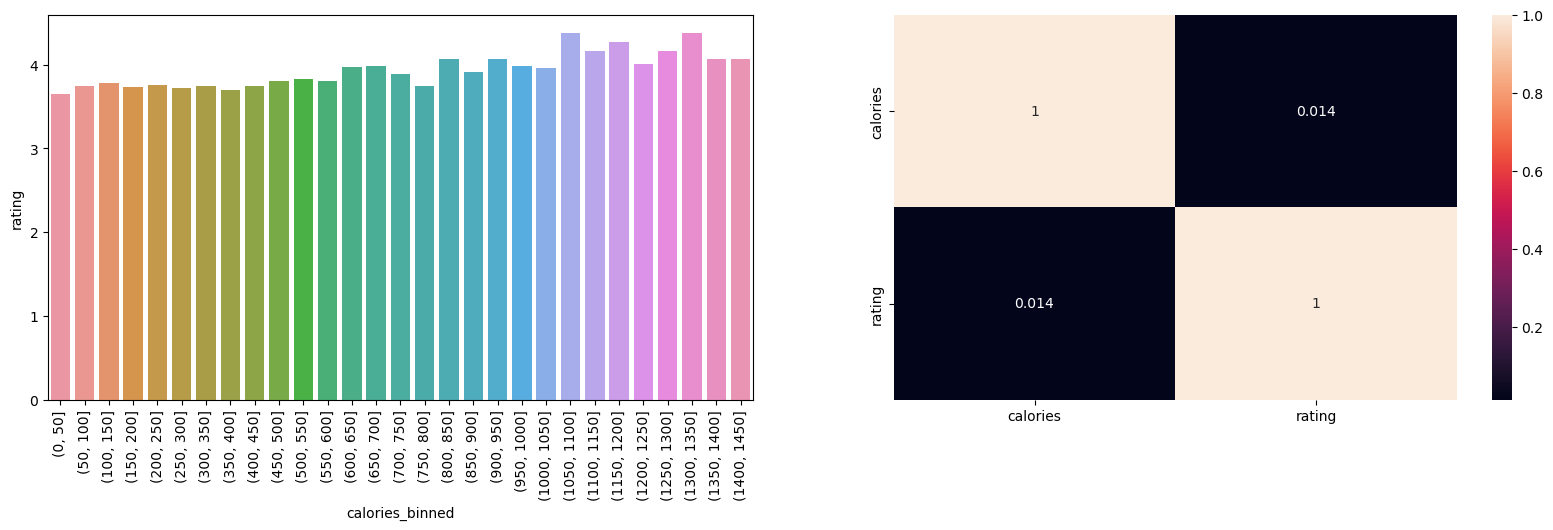

In [111]:
aux1 = df4[['calories', 'rating']].groupby('calories').mean().reset_index()


plt.subplot (1, 2, 1)
bins = list(np.arange(0, 1500, 50))

aux1['calories_binned'] = pd.cut(aux1['calories'], bins = bins)
aux2 = aux1[['calories_binned', 'rating']].groupby('calories_binned').median().reset_index()

sns.barplot(x = 'calories_binned', y = 'rating', data = aux2);
plt.xticks(rotation = 90);

plt.subplot (1, 2, 2)
sns.heatmap (df4[['calories', 'rating']].corr (method = 'pearson'), annot = True);

#### H2. Receitas com mais proteínas deveriam possuir mais rating.
**VERDADEIRO**

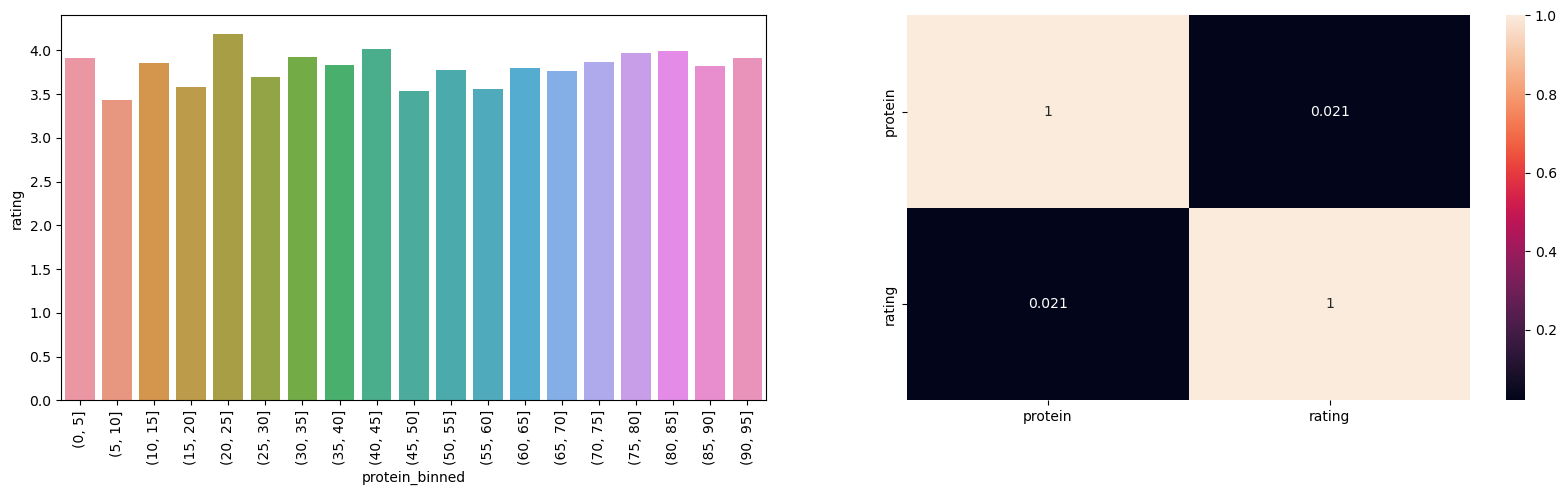

In [112]:
aux1 = df4[['protein', 'rating']].groupby('protein').mean().reset_index()

plt.subplot (1, 2, 1)
bins = list(np.arange(0, 100, 5))

aux1['protein_binned'] = pd.cut(aux1['protein'], bins = bins)
aux2 = aux1[['protein_binned', 'rating']].groupby('protein_binned').mean().reset_index()

sns.barplot(x = 'protein_binned', y = 'rating', data = aux2);
plt.xticks(rotation = 90);

plt.subplot (1, 2, 2)
sns.heatmap (df4[['protein', 'rating']].corr (method = 'pearson'), annot = True);

#### H3. Receitas veganas deveriam possuir menos rating.
**FALSO**. Há um ligeiro aumento no rating de receitas veganas

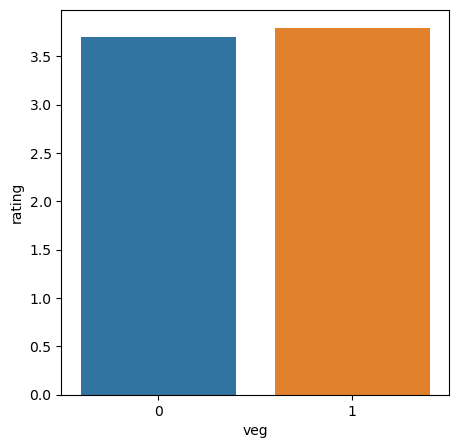

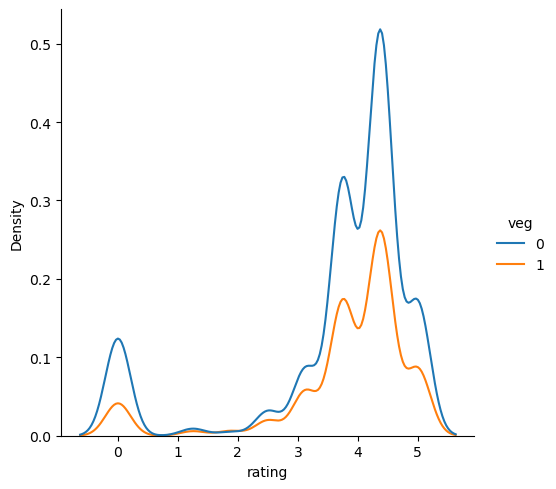

In [113]:
plt.rcParams['figure.figsize'] = [5, 5]
aux1 = df4[['veg', 'rating']].groupby('veg').mean().reset_index()
sns.barplot (x = 'veg', y = 'rating', data = aux1);

sns.displot(data=df4, x='rating', hue='veg', kind="kde");

#### H4. Sobremesas deveriam possuir maior rating.
**VERDADEIRO**

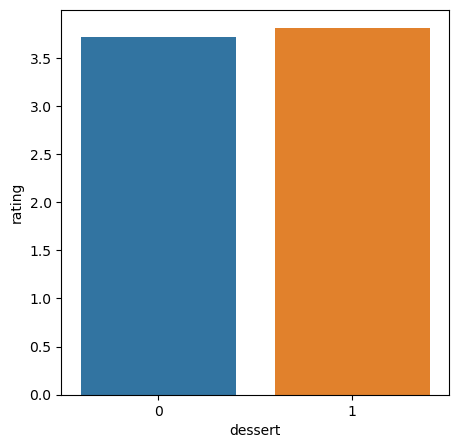

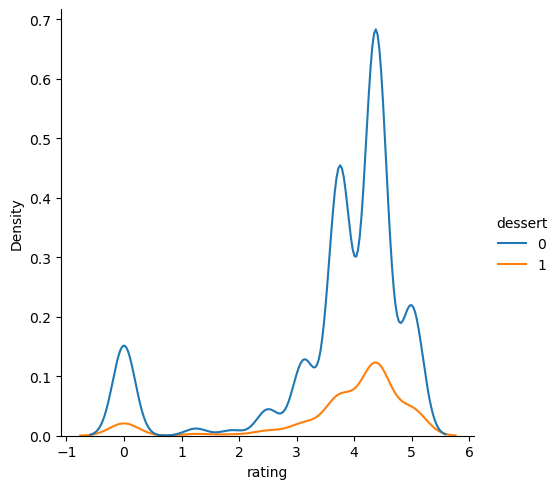

In [114]:
plt.rcParams['figure.figsize'] = [5, 5]
aux1 = df4[['dessert', 'rating']].groupby('dessert').mean().reset_index()
sns.barplot (x = 'dessert', y = 'rating', data = aux1);

sns.displot(data=df4, x='rating', hue='dessert', kind="kde");

#### H5. Churrascos deveriam possuir mais rating.
**VERDADEIRO**

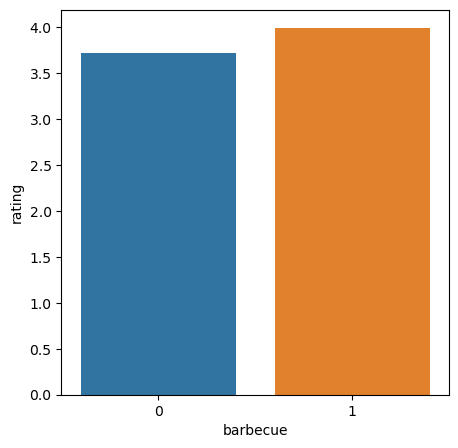

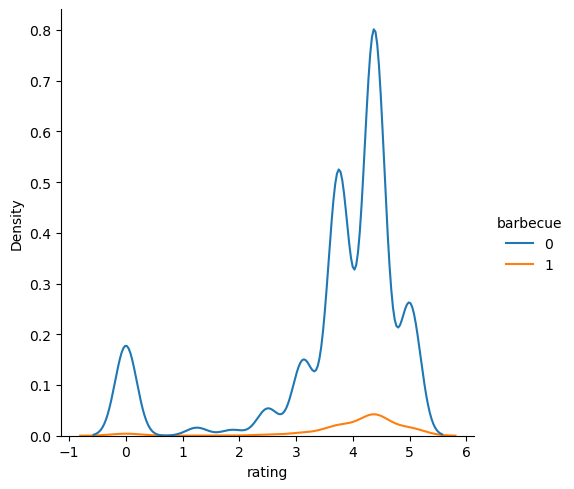

In [115]:
plt.rcParams['figure.figsize'] = [5, 5]
aux1 = df4[['barbecue', 'rating']].groupby('barbecue').mean().reset_index()
sns.barplot (x = 'barbecue', y = 'rating', data = aux1);

sns.displot(data=df4, x='rating', hue='barbecue', kind='kde');

#### H6. Receitas postadas próximas ao Natal deveriam possuir mais rating.
**FALSO** - Há pouca correlação entre as variáveis.

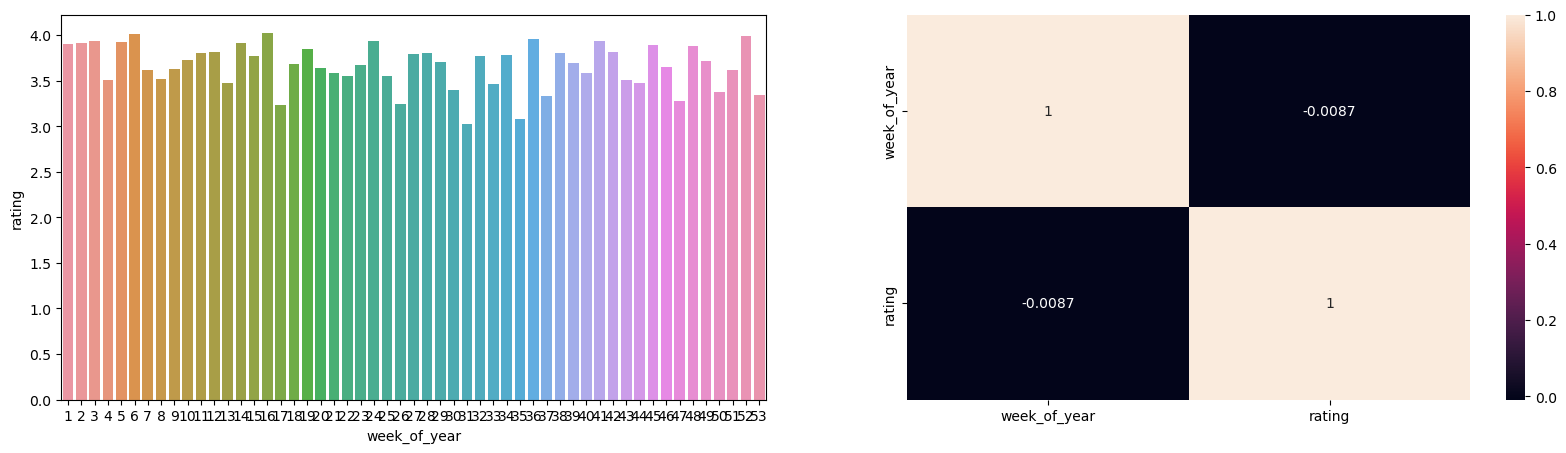

In [116]:
plt.rcParams['figure.figsize'] = [20, 5]
aux1 = df4[['week_of_year', 'rating']].groupby('week_of_year').mean().reset_index()
plt.subplot (1, 2, 1)
sns.barplot (x = 'week_of_year', y = 'rating', data = aux1);

plt.subplot (1, 2, 2)
sns.heatmap (df4[['week_of_year', 'rating']].corr (method = 'pearson'), annot = True);

#### H7. Receitas postadas próximas no verão deveriam possuir mais rating.
**VERDADEIRO**

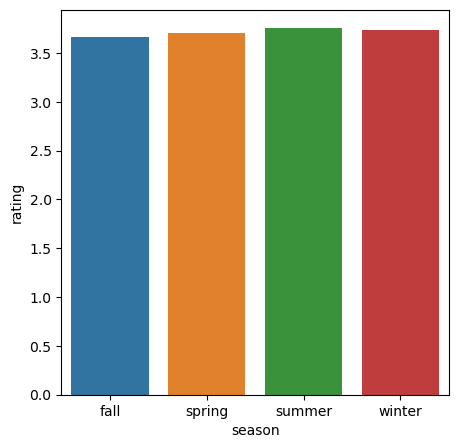

In [126]:
plt.rcParams['figure.figsize'] = [5, 5]
aux1 = df4[['season', 'rating']].groupby('season').mean().reset_index()
sns.barplot (x = 'season', y = 'rating', data = aux1);

#### 8. Rating médio deveria aumentar com o passar dos anos.
**FALSO**. Há uma diminuição de rating com o passar dos anos.

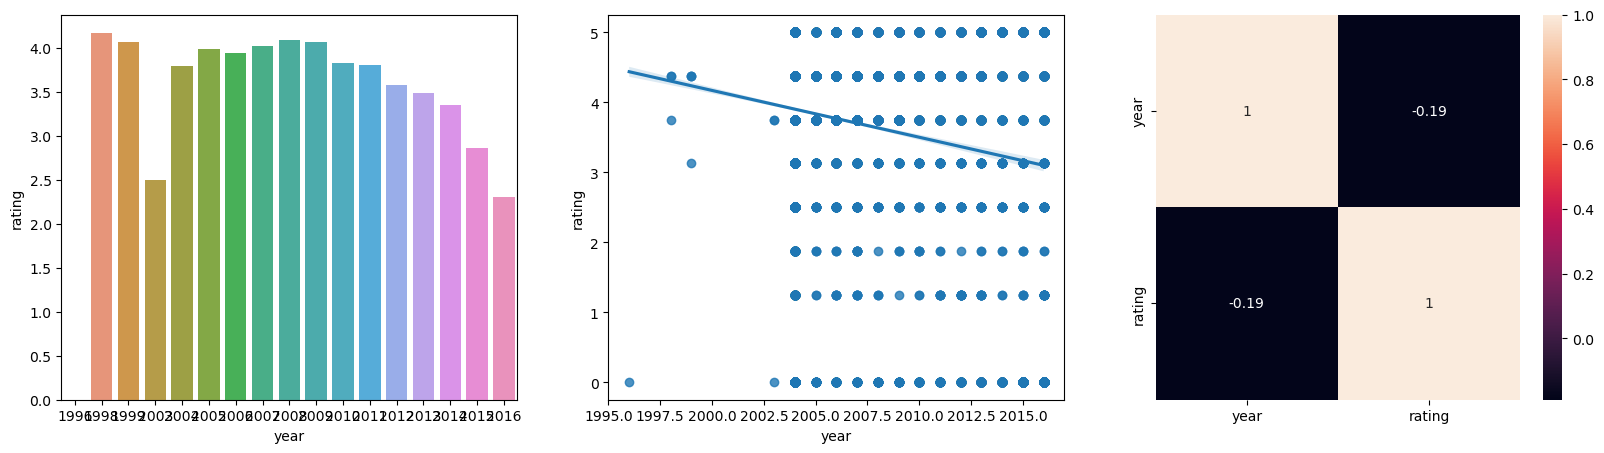

In [118]:
plt.rcParams['figure.figsize'] = [20, 5]

aux1 = df4[['year', 'rating']].groupby('year').mean().reset_index()
plt.subplot (1, 3, 1)
sns.barplot (x = 'year', y = 'rating', data = aux1);

plt.subplot (1, 3, 2)
sns.regplot (x = 'year', y = 'rating', data = df4);

plt.subplot (1, 3, 3)
sns.heatmap (df4[['year', 'rating']].corr (method = 'pearson'), annot = True);

#### H9. Receitas postadas no verão deveriam ter mais calorias.
**FALSO** - Receitas postadas no inverno possuem mais calorias.

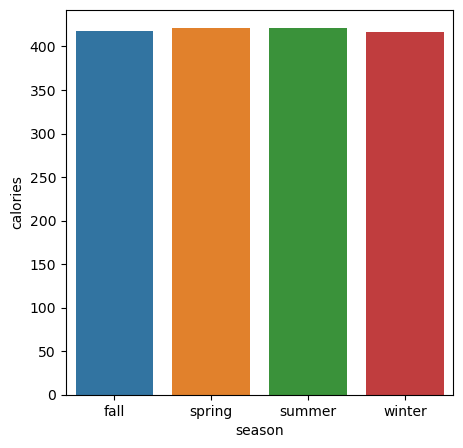

In [119]:
plt.rcParams['figure.figsize'] = [5, 5]
aux1 = df4[['season', 'calories']].groupby('season').mean().reset_index()
sns.barplot (x = 'season', y = 'calories', data = aux1);

#### H10. Receitas veganas deveriam possuir menos proteínas.
**VERDADEIRO**

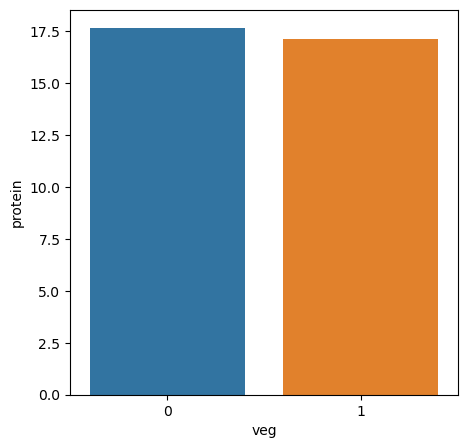

In [120]:
plt.rcParams['figure.figsize'] = [5, 5]
aux1 = df4[['veg', 'protein']].groupby('veg').mean().reset_index()
sns.barplot (x = 'veg', y = 'protein', data = aux1);

#### H11. Receitas do tipo *Healthy* deveriam possuir menos gorduras
**FALSO** - Não há grandes alterações.

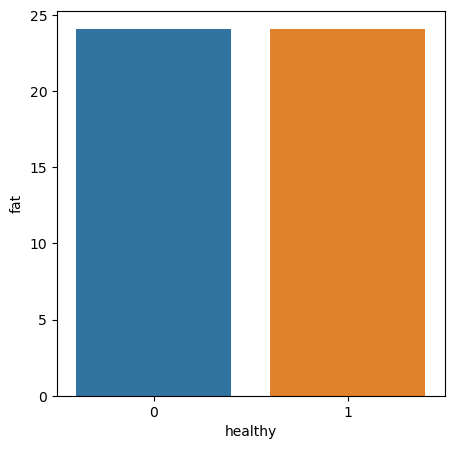

In [130]:
plt.rcParams['figure.figsize'] = [5, 5]
aux1 = df4[['healthy', 'fat']].groupby('healthy').mean().reset_index()
sns.barplot (x = 'healthy', y = 'fat', data = aux1);

#### 4.2.1 - Resumo das Hipóteses

### 4.3. Análise Multivariada

In [122]:
num_attributes = df4.select_dtypes (include = ['float64', 'int64'])

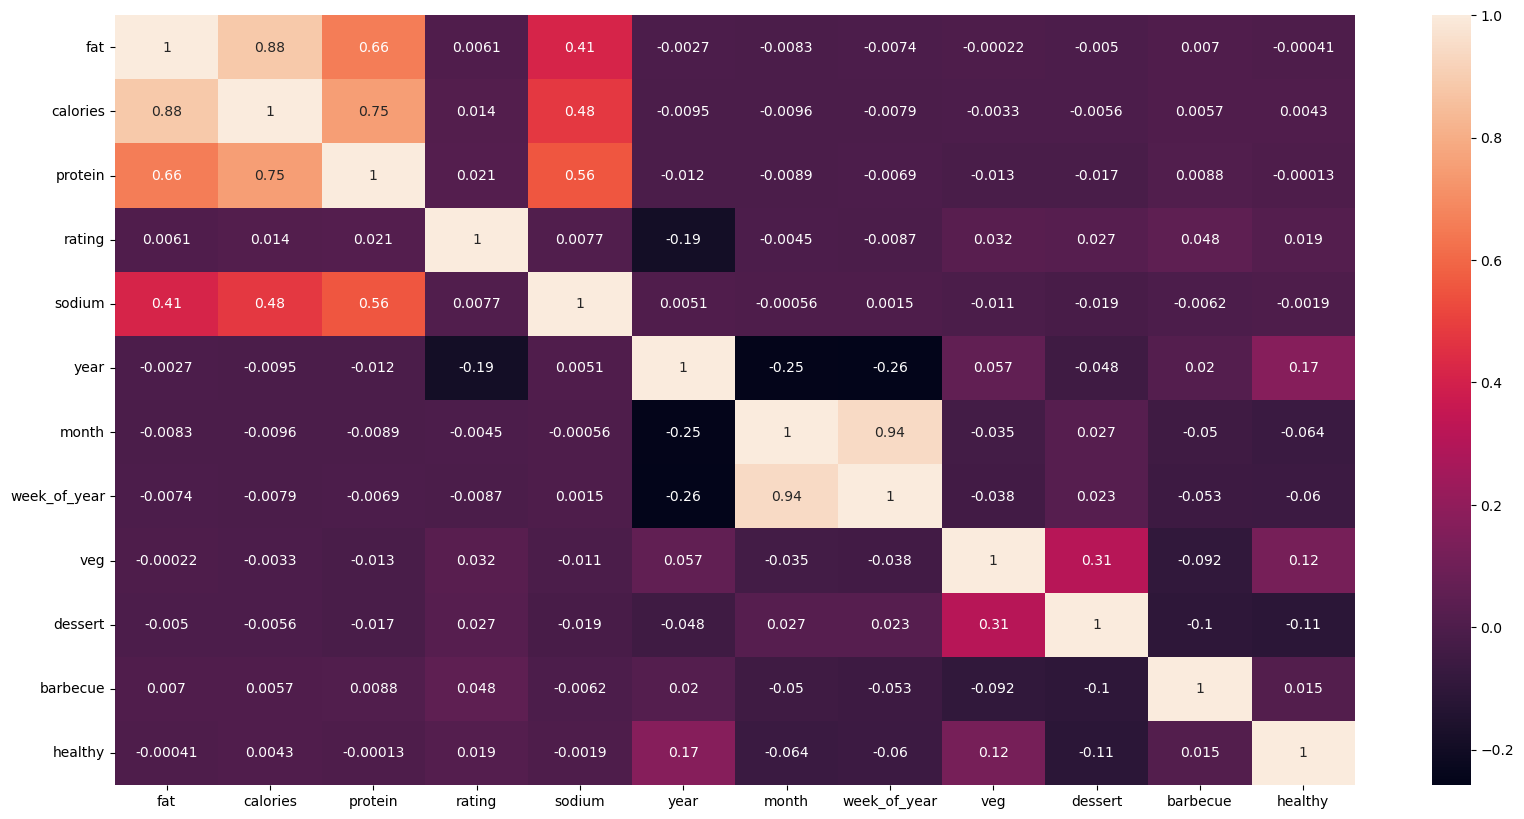

In [123]:
plt.rcParams['figure.figsize'] = [20, 10]
correlation = num_attributes.corr (method = 'pearson')
sns.heatmap (correlation, annot = True);

**1.** Como esperado, há uma grande correlação entre as features nutricionais.